In [11]:
!apt update
!apt-get install libglu1 -y
!pip install kornia_moons --upgrade
!pip install opencv-python
!pip install opencv-contrib-python
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install pydegensac

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Fetched 336 kB in 0s (674 kB/s)               
Reading package lists... Done
Building dependency tree       
Reading state information... Done
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libglu1-mesa' instead of 'libglu1'
libglu1-mesa is already the newest version (9.0.1-1build1).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking i

In [12]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


QUADRANT 1:
0 deg: 

/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/opt/conda/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % 

TotPts: [107]; PtsWConf>0.5: 17; avgConf: 0.355; USAC match: 14; DEGENSAC match: 11; Acc match: 1;
90 deg: TotPts: [108]; PtsWConf>0.5: 14; avgConf: 0.350; USAC match: 13; DEGENSAC match: 12; Acc match: 1;
180 deg: TotPts: [133]; PtsWConf>0.5: 19; avgConf: 0.336; 
270 deg: TotPts: [96]; PtsWConf>0.5: 13; avgConf: 0.343; 
Time after time for Q1: 3.3374698162078857
QUADRANT 2:
0 deg: TotPts: [104]; PtsWConf>0.5: 18; avgConf: 0.350; 
90 deg: TotPts: [148]; PtsWConf>0.5: 21; avgConf: 0.350; 
180 deg: TotPts: [95]; PtsWConf>0.5: 13; avgConf: 0.347; 
270 deg: TotPts: [100]; PtsWConf>0.5: 13; avgConf: 0.345; 
Time after time for Q2: 2.1867623329162598
QUADRANT 3:
0 deg: TotPts: [94]; PtsWConf>0.5: 13; avgConf: 0.353; USAC match: 13; DEGENSAC match: 11; Acc match: 4;
90 deg: TotPts: [103]; PtsWConf>0.5: 16; avgConf: 0.339; 
180 deg: TotPts: [93]; PtsWConf>0.5: 17; avgConf: 0.350; USAC match: 15; DEGENSAC match: 13; Acc match: 5;
270 deg: TotPts: [76]; PtsWConf>0.5: 11; avgConf: 0.322; 
Time af

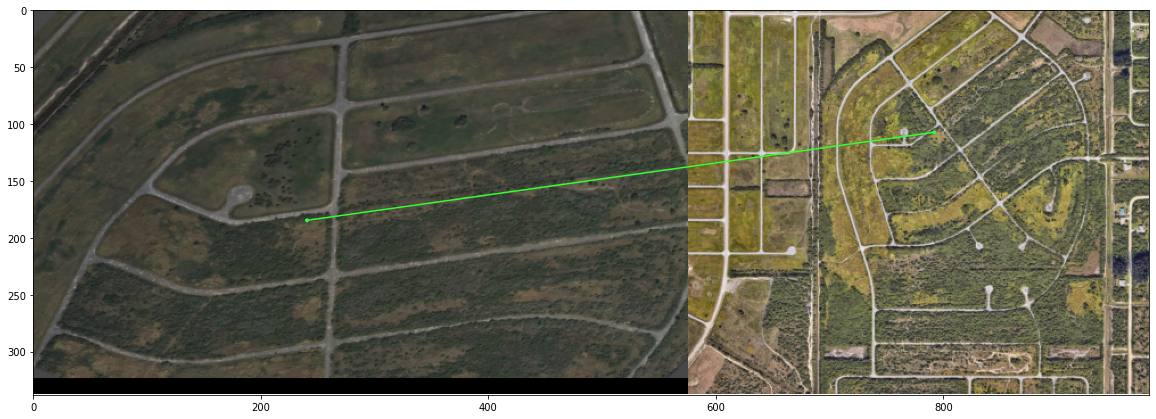

In [8]:
import pydegensac
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *
import time
import imutils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def resize(scale,img):
    scale_percent = scale  # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized

def load_torch_image(fname,s, rot=0):
    img= cv2.imread(fname)
    if rot!=0:
        img = imutils.rotate_bound(img, rot)
    img=resize(s,img)
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    img=img.to(device)
    return img

def iterRot(rotImgs=[],img2=None):
    acc=[0,0,0,0]
    true_inliers=[]
    true_mkpoints=[]
    #rotImgs=rotImgs if rotImgs != [] else [load_torch_image(img1Dir,25,a*90) for a in range(4)]
    for t in range(4):
        print(f'{t*90} deg:',end=' ')
        tstImg = rotImgs[t]
        quadImg = img2#load_torch_image(img2Dir,30)
        matcher = KF.LoFTR(pretrained='outdoor')
        matcher = matcher.eval().cuda()
        input_dict = {"image0": K.color.rgb_to_grayscale(tstImg), # LofTR works on grayscale images only 
                      "image1": K.color.rgb_to_grayscale(quadImg)}
        with torch.no_grad():
            correspondences = matcher(input_dict)
        filtParams=[torch.count_nonzero(correspondences['confidence']>0.5),torch.mean(correspondences['confidence']),list(correspondences['confidence'].size())]
        print(f"TotPts: {filtParams[2]}; PtsWConf>0.5: {filtParams[0]}; avgConf: {filtParams[1]:.3f};", end=' ')        
        if(filtParams[1]<0.35 or filtParams[2][0]<8):
            true_inliers.append([])
            true_mkpoints.append([])
            print()
            continue
        mkpts0 = correspondences['keypoints0'].cpu().numpy()
        mkpts1 = correspondences['keypoints1'].cpu().numpy()
        true_mkpoints.append([mkpts0, mkpts1])
        H1, inliers1 = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.9999, 100000)
        inliers1 = inliers1 > 0
        H2, inliers2 = pydegensac.findFundamentalMatrix(mkpts0, mkpts1, 0.4)
        print(f'USAC match: {np.count_nonzero(inliers1 == True)};', end=' ')
        print(f'DEGENSAC match: {np.count_nonzero(inliers2 == True)};', end=' ')
        inliers_i= []
        for i,k in enumerate(inliers1):
            if(k[0]==True and inliers2[i]==True):
                inliers_i.append(True)
                acc[t]+=1
            else:
                inliers_i.append(False)
        print(f'Acc match: {acc[t]};')
        true_inliers.append(inliers_i)
        if acc[t]>20:
            break
    bett_acc=[]
    for i in acc:
        bett_acc.append(float(filtParams[1]*i))
    return bett_acc,true_mkpoints, true_inliers

def quadIter(img1List=[], img2List=[]):
    prt_acr=[]
    prt_mkpts=[]
    prt_inliers=[]
    for q in range(4):
        print(f'QUADRANT {q+1}:')
        start2=time.time()
        #fname2 = '../../Data/NewLSTemplates/newLS_sat_'+str(q)+'-4_highQ.png'#'rectified.jpg'
        n_acr,n_mkpts,n_inliers=iterRot(img1List,mapImg[q])
        prt_acr.extend(n_acr)
        prt_mkpts+=n_mkpts
        prt_inliers+=n_inliers
        print(f'Time after time for Q{q+1}: {time.time()-start2}')
    return prt_acr, prt_mkpts, prt_inliers

def subdivisions(img2Dir, scale=25):
    image = cv2.imread(img2Dir)
    (h, w) = image.shape[:2]
    # compute the center coordinate of the image
    (cX, cY) = (w // 2, h // 2)
    #cv2.imshow('Original', image)
    imgs=[image[0:cY, 0:cX],image[0:cY, cX:w],image[cY:h, 0:cX],image[cY:h, cX:w]]
    new_imgs=[]
    for i,k in enumerate(imgs):
        new_imgs.append(resize(scale,k))
        new_imgs[i]=K.image_to_tensor(new_imgs[i], False).float() /255.
        new_imgs[i]=K.color.bgr_to_rgb(new_imgs[i])
        new_imgs[i]=new_imgs[i].to(device)
    return new_imgs
def mid_points(x,y,z):
    total = 0
    total2 = 0
    total3 = 0
    total4 = 0
    filter1 = 0
    for i in range(len(x)):
        if z[i]:
            s = x[i]
            total = total + s[0]
    for k in range(len(x)):
        if z[k]:
            n = x[k]
            total2 = total2 + n[1]
    for v in range(len(y)):
        if z[v]:
            v = y[v]
            total3 = total3 + v[0]
    for j in range(len(y)):
        if z[j]:
            m = y[j]
            total4 = total4 + m[1]
            filter1+=1
    xyt = [(1/filter1)*total, (1/filter1)*total2]
    xyt2 = [(1/filter1)*total3, (1/filter1)*total4]
    return [xyt, xyt2]

def main(rocketImage, satImage, showResults=False, whatToShow="All"):
    start=time.time()
    fname1 = rocketImage
    fname2= satImage
    vidImg=[load_torch_image(fname1,30,a*90) for a in range(4)]
    mapImg=subdivisions(fname2,30)
    p_acr, p_mkpts, p_inliers=quadIter(vidImg, mapImg)
    f=p_acr.index(max(p_acr))    
    f_img1 = vidImg[f-int(f/4)*4]
    f_img2 = mapImg[int(f/4)]
    f_inliers=np.array(p_inliers[f])
    f_mkpts0=np.array(p_mkpts[f][0])
    f_mkpts1=np.array(p_mkpts[f][1])

    print(f'The final countdown: {time.time()-start}')

    print(f'Winner: {f} --> Quadrant {int(f/4)+1}')
    print(len(f_mkpts1))
    print(len(f_inliers))
    print(p_acr)
    f_keypoints = mid_points(f_mkpts0,f_mkpts1,f_inliers)
    #print(f_keypoints)
    if (whatToShow=="Midpoint"):
        f_mkpts0 = np.array([f_keypoints[0]])
        f_mkpts1 =  np.array([f_keypoints[1]])
        f_inliers =  np.array([True])
    if(showResults):
        draw_LAF_matches(
            KF.laf_from_center_scale_ori(torch.from_numpy(f_mkpts0).view(1,-1, 2),
                                        torch.ones(f_mkpts0.shape[0]).view(1,-1, 1, 1),
                                        torch.ones(f_mkpts0.shape[0]).view(1,-1, 1)),

            KF.laf_from_center_scale_ori(torch.from_numpy(f_mkpts1).view(1,-1, 2),
                                        torch.ones(f_mkpts1.shape[0]).view(1,-1, 1, 1),
                                        torch.ones(f_mkpts1.shape[0]).view(1,-1, 1)),
            torch.arange(f_mkpts0.shape[0]).view(-1,1).repeat(1,2),
            K.tensor_to_image(f_img1),
            K.tensor_to_image(f_img2),
            f_inliers,
            draw_dict={'inlier_color': (0.2, 1, 0.2),
                       'tentative_color': None, 
                       'feature_color': (0.2, 0.5, 1), 'vertical': False})
    return f_keypoints
coords=main('../../Data/3D_sim_tests/newLS_drone_3Drot1_180_highQ.png','../../Data/NewLSTemplates/newLS_sat_highQ.png', True, "Midpoint")
print(coords)

In [10]:
import eyeinthesky
eyeinthesky.main('../../Data/3D_sim_tests/newLS_drone_3Drot1_180_highQ.png','../../Data/NewLSTemplates/newLS_sat_highQ.png', True, "Midpoint")

QUADRANT 1:


NameError: name 'mapImg' is not defined